<a href="https://colab.research.google.com/github/muajnstu/Large_Scale_Implementation_of_DSK_Chain/blob/main/BCD_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/muajnstu/ML-Datasets/refs/heads/main/breast-cancer-data.csv")
df

,age,menopause,tumer-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate,class
0,40-49',premeno',15-19',0-2',yes',3',right',left_up',no',recurrence-events'
1,50-59',ge40',15-19',0-2',no',1',right',central',no',no-recurrence-events'
2,50-59',ge40',35-39',0-2',no',2',left',left_low',no',recurrence-events'
3,40-49',premeno',35-39',0-2',yes',3',right',left_low',yes',no-recurrence-events'
4,40-49',premeno',30-34',3-5',yes',2',left',right_up',no',recurrence-events'
...,...,...,...,...,...,...,...,...,...,...
281,50-59',ge40',30-34',6-8',yes',2',left',left_low',no',no-recurrence-events'
282,50-59',premeno',25-29',3-5',yes',2',left',left_low',yes',no-recurrence-events'
283,30-39',premeno',30-34',6-8',yes',2',right',right_up',no',no-recurrence-events'
284,50-59',premeno',15-19',0-2',no',2',right',left_low',no',no-recurrence-events'


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumer-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    278 non-null    object
 5   deg-malig    286 non-null    object
 6   breast       286 non-null    object
 7   breast-quad  285 non-null    object
 8   irradiate    286 non-null    object
 9   class        286 non-null    object
dtypes: object(10)
memory usage: 22.5+ KB


In [ ]:
print(df.shape)

(286, 10)


1. Basic Cleaning

In [ ]:
missing_per_column = df.isnull().sum()
print("Missing values per column:")
print(missing_per_column)

print("Total missing values in all columns:", missing_per_column.sum())

missing_per_row = df.isnull().sum(axis=1)
print("Missing values per row:")
print(missing_per_row)

print("Total missing values in all rows:", missing_per_row.sum())

# Total missing values in the dataset
total_missing = df.isnull().sum().sum()
print("Total missing values in the dataset:", total_missing)

Missing values per column:
age            0
menopause      0
tumer-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiate      0
class          0
dtype: int64
Total missing values in all columns: 9
Missing values per row:
0      0
1      0
2      0
3      0
4      0
      ..
281    0
282    0
283    0
284    0
285    0
Length: 286, dtype: int64
Total missing values in all rows: 9
Total missing values in the dataset: 9


In [ ]:
def delta(a, b):
    """Return 1 if a == b, else 0."""
    return int(a == b)


def impute_sim_hamm(row, complete_df, target_col, compare_cols):
    """
    Impute missing categorical values using similarity-based Hamming distance.

    Parameters:
    ----------
    row : pandas.Series
        The row with missing value.
    complete_df : pandas.DataFrame
        Subset of data without missing target values.
    target_col : str
        Column name to impute.
    compare_cols : list
        Columns to calculate similarity on.
    """
    complete_df = complete_df.dropna(subset=compare_cols)

    # Print the number of complete rows being used
    # print(f"Number of complete rows for imputation: {len(complete_df)}")


    sim_scores = [
        (comp[target_col], sum(delta(row[c], comp[c]) for c in compare_cols))
        for _, comp in complete_df.iterrows()
    ]

    # Find maximum similarity score
    if not sim_scores:
        return np.nan

    max_score = max(score for _, score in sim_scores)
    top_sim = [val for val, score in sim_scores if score == max_score]

    # Majority vote among top similar rows
    count = Counter(top_sim)

    # If tie,Hamming distance to break it
    if len(count) > 1:
        hamm_scores = [
            (comp[target_col], sum(row[c] != comp[c] for c in compare_cols))
            for _, comp in complete_df.iterrows()
        ]
        min_hamm = min(h[1] for h in hamm_scores)
        candidates = [h[0] for h in hamm_scores if h[1] == min_hamm]
        return Counter(candidates).most_common(1)[0][0]

    return list(count.keys())[0]



def handle_missing_values(df):
    """
    Cleans and imputes missing values for 'node_caps' and 'breast_quad'.
    Uses:
      - Mode imputation for node_caps
      - KNN Imputation for breast_quad
    """
    df = df.copy()

    # --- Handle 'node-caps' using Mode Imputation ---
    if df['node-caps'].isnull().any():
        mode_node_caps = df['node-caps'].mode()[0]
        df['node-caps'] = df['node-caps'].fillna(mode_node_caps)
        print(f"Imputed missing 'node-caps' with mode: {mode_node_caps}")


    # --- Handle 'breast-quad' using KNN ---
    if df['breast-quad'].isnull().any():
        df_bq = df.copy()
        df_bq['breast-quad_cat'] = df_bq['breast-quad'].astype('category')
        df_bq['breast-quad_code'] = df_bq['breast-quad_cat'].cat.codes.replace(-1, np.nan)

        knn_imputer = KNNImputer(n_neighbors=5)
        # Reshape for KNNImputer
        breast_quad_code_reshaped = df_bq[['breast-quad_code']]
        df_bq[['breast-quad_code']] = knn_imputer.fit_transform(breast_quad_code_reshaped)

        mapping = dict(enumerate(df_bq['breast-quad_cat'].cat.categories))
        df['breast-quad'] = df_bq['breast-quad_code'].round().astype(int).map(mapping)
        print("Imputed missing 'breast-quad' using KNN.")


    print("✅ Missing data handled successfully!")
    print("\nRemaining missing values:\n")
    print(df.isna().sum())

    return df

In [ ]:
# Store indices of missing values *before* imputation
missing_node_caps_idx = df[df['node-caps'].isna()].index
missing_breast_quad_idx = df[df['breast-quad'].isna()].index

df_imputed = handle_missing_values(df)

# Show exactly those that were imputed
print("\n🩺 Rows where 'node-caps' was imputed:")
print(df_imputed.loc[missing_node_caps_idx, ['age', 'tumer-size', 'deg-malig', 'irradiate', 'node-caps']])

print("\n🧬 Row where 'breast-quad' was imputed:")
print(df_imputed.loc[missing_breast_quad_idx, ['age', 'tumer-size', 'deg-malig', 'irradiate', 'breast-quad']])

Imputed missing 'node-caps' with mode: no'
Imputed missing 'breast-quad' using KNN.
✅ Missing data handled successfully!

Remaining missing values:

age            0
menopause      0
tumer-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiate      0
class          0
dtype: int64

🩺 Rows where 'node-caps' was imputed:
        age tumer-size deg-malig irradiate node-caps
20   50-59'     20-24'        1'       no'       no'
31   60-69'     25-29'        1'      yes'       no'
50   70-79'     15-19'        1'      yes'       no'
54   40-49'     25-29'        2'      yes'       no'
71   60-69'     25-29'        1'      yes'       no'
92   50-59'     20-24'        1'       no'       no'
149  50-59'     30-34'        3'      yes'       no'
264  50-59'     30-34'        3'      yes'       no'

🧬 Row where 'breast-quad' was imputed:
        age tumer-size deg-malig irradiate breast-quad
240  50-59'     30-34'        3'       no'    left_up'


In [ ]:
df_imputed.isnull().sum()

,0
age,0
menopause,0
tumer-size,0
inv-nodes,0
node-caps,0
deg-malig,0
breast,0
breast-quad,0
irradiate,0
class,0


In [ ]:
duplicate_rows = df.duplicated()
print("Duplicate rows (True means duplicate):")
print(duplicate_rows)

# Total number of duplicate rows
total_duplicates = duplicate_rows.sum()
print("Total number of duplicate rows:", total_duplicates)

Duplicate rows (True means duplicate):
0      False
1      False
2      False
3      False
4      False
       ...  
281    False
282    False
283    False
284    False
285    False
Length: 286, dtype: bool
Total number of duplicate rows: 14


In [ ]:
df[df.duplicated(keep=False)].sort_values(by=list(df.columns))

# Remove exact duplicates
df.drop_duplicates(inplace=True)

# Verify removal
print("Remaining duplicate rows:", df.duplicated().sum())

duplicates = df[df.duplicated(keep=False)]
duplicates.to_csv("removed_duplicates.csv", index=False)

Remaining duplicate rows: 0


In [ ]:
df.describe()

,age,menopause,tumer-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate,class
count,272,272,272,272,264,272,272,271,272,272
unique,6,3,11,7,2,3,2,5,2,2
top,50-59',premeno',30-34',0-2',no',2',left',left_low',no',no-recurrence-events'
freq,91,143,60,200,209,124,143,103,205,191


2. Features Visualization

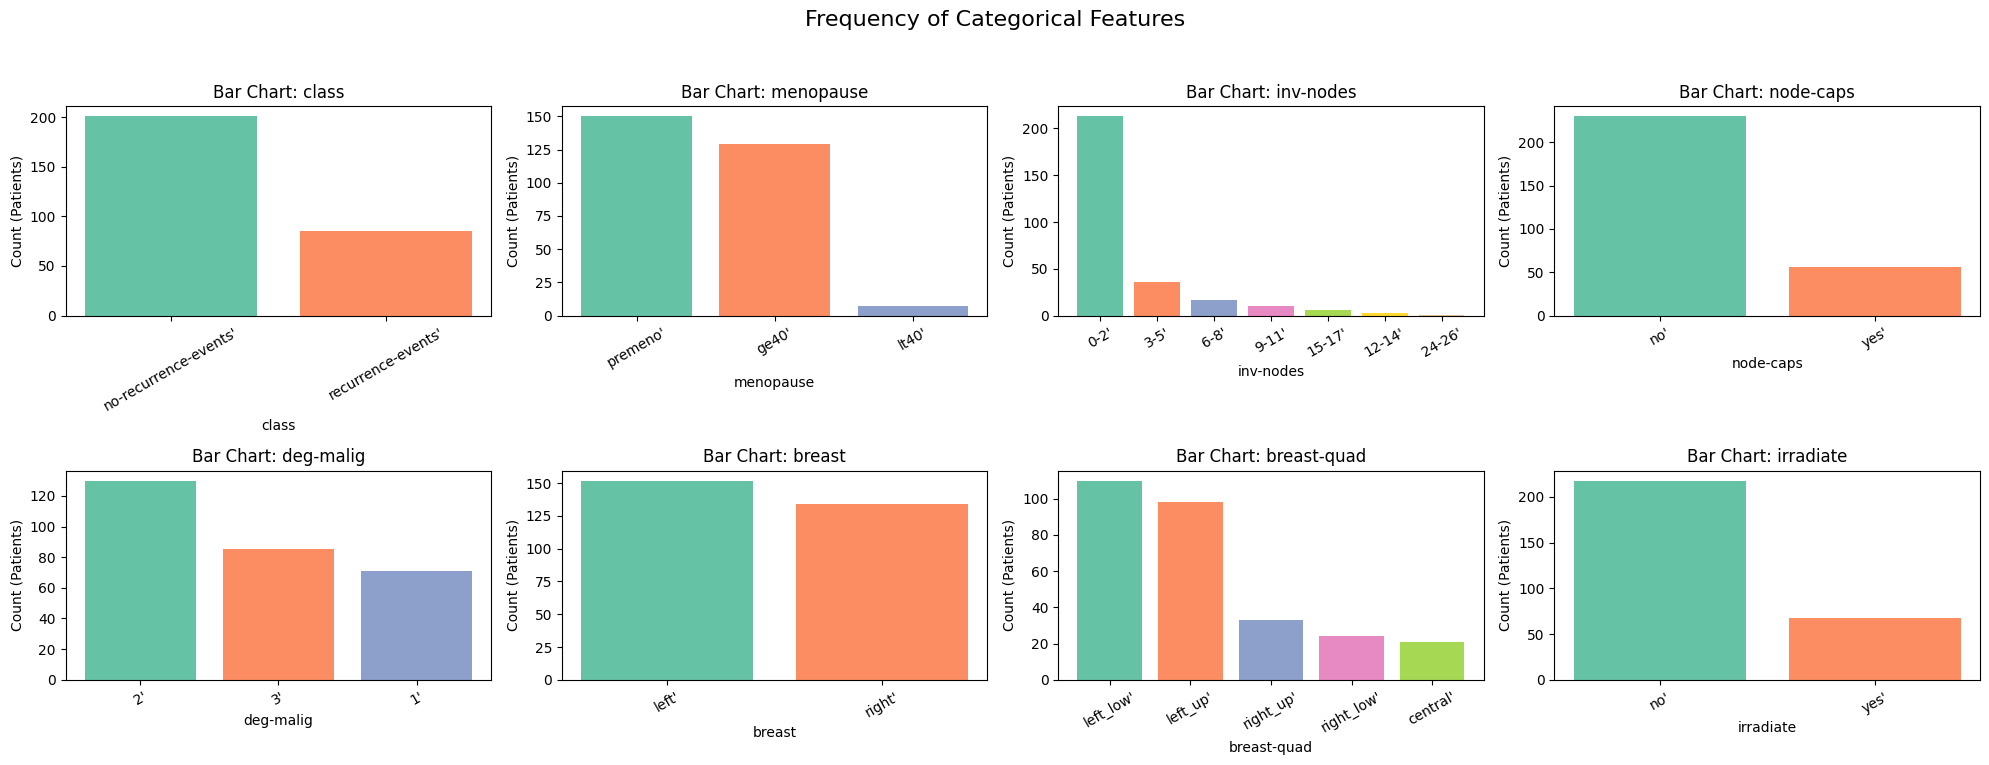

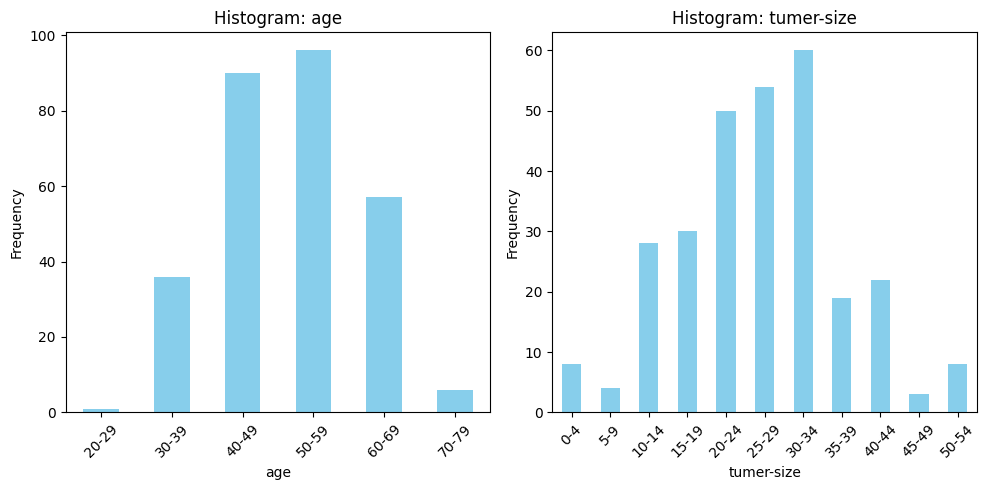

In [ ]:
#df_imputed is DataFrame after handling missing values

# Separate categorical and numerical-like features for plotting
categorical_cols = ['class', 'menopause', 'inv-nodes', 'node-caps',
                    'deg-malig', 'breast', 'breast-quad', 'irradiate']

# Features that are categorical but have ordered categories or ranges
ordered_categorical_cols = ['age', 'tumer-size']

n_categorical = len(categorical_cols)
n_cols_categorical = 4
n_rows_categorical = (n_categorical + n_cols_categorical - 1) // n_cols_categorical

fig, axes = plt.subplots(n_rows_categorical, n_cols_categorical, figsize=(20, n_rows_categorical * 4))
fig.suptitle('Frequency of Categorical Features', fontsize=16)
axes = axes.flatten() # Flatten the axes array for easy iteration

for i, column in enumerate(categorical_cols):
    counts = df_imputed[column].value_counts()
    bars = axes[i].bar(counts.index.astype(str), counts.values, color=sns.color_palette("Set2", n_colors=len(counts)))
    axes[i].set_title('Bar Chart: '+ column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count (Patients)')
    axes[i].tick_params(axis='x', rotation=30)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



category_map = {
    'age': ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79'],
    'tumer-size': ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29',
                   '30-34', '35-39', '40-44', '45-49', '50-54']
}

df_plot = df_imputed.copy()

for col, cat_order in category_map.items():
    # Remove trailing apostrophe from column values
    df_plot[col] = df_plot[col].astype(str).str.replace("'", "")
    df_plot[col] = pd.Categorical(df_plot[col], categories=cat_order, ordered=True)

plt.figure(figsize=(10, 5)) # Adjusted figure size for fewer plots
for i, feature in enumerate(ordered_categorical_cols):
    plt.subplot(1, len(ordered_categorical_cols), i + 1) # Dynamic subplot creation
    df_plot[feature].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(f'Histogram: {feature}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

3. ENCODING Processes

In [ ]:
#ENCODING
df_encoded = df_imputed.copy()


# Define columns for different encoding methods
one_hot_encode_cols = ['tumer-size']

# Define columns for mapping, including age
mapping_cols = ['age', 'menopause', 'node-caps', 'deg-malig', 'breast', 'irradiate', 'class', 'inv-nodes', 'breast-quad']

# Define the order for ordinal encoding of 'age'
age_order = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

# Apply Mapping
for col in mapping_cols:
    # Remove trailing apostrophe
    df_encoded[col] = df_encoded[col].astype(str).str.replace("'", "")

    if col == 'age':
        # Create mapping based on the defined order for age
        mapping = {value: i for i, value in enumerate(age_order)}
        # Handle any values not in the defined order (though none exist in this dataset)
        df_encoded[col] = df_encoded[col].map(mapping).fillna(-1).astype(int)
    else:
        # Create mapping based on unique values for other columns
        unique_values = df_encoded[col].unique()
        mapping = {value: i for i, value in enumerate(unique_values)}
        df_encoded[col] = df_encoded[col].map(mapping)

    print(f"Mapping for '{col}': {mapping}") # Print the mapping


# Apply One-Hot Encoding
df_encoded = pd.get_dummies(df_encoded, columns=one_hot_encode_cols, prefix=one_hot_encode_cols)

# Display the head of the encoded DataFrame
display(df_encoded.head())

Mapping for 'age': {'20-29': 0, '30-39': 1, '40-49': 2, '50-59': 3, '60-69': 4, '70-79': 5}
Mapping for 'menopause': {'premeno': 0, 'ge40': 1, 'lt40': 2}
Mapping for 'node-caps': {'yes': 0, 'no': 1}
Mapping for 'deg-malig': {'3': 0, '1': 1, '2': 2}
Mapping for 'breast': {'right': 0, 'left': 1}
Mapping for 'irradiate': {'no': 0, 'yes': 1}
Mapping for 'class': {'recurrence-events': 0, 'no-recurrence-events': 1}
Mapping for 'inv-nodes': {'0-2': 0, '3-5': 1, '15-17': 2, '6-8': 3, '9-11': 4, '24-26': 5, '12-14': 6}
Mapping for 'breast-quad': {'left_up': 0, 'central': 1, 'left_low': 2, 'right_up': 3, 'right_low': 4}


,age,menopause,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate,class,tumer-size_0-4',tumer-size_10-14',tumer-size_15-19',tumer-size_20-24',tumer-size_25-29',tumer-size_30-34',tumer-size_35-39',tumer-size_40-44',tumer-size_45-49',tumer-size_5-9',tumer-size_50-54'
0,2,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False
1,3,1,0,1,1,0,1,0,1,False,False,True,False,False,False,False,False,False,False,False
2,3,1,0,1,2,1,2,0,0,False,False,False,False,False,False,True,False,False,False,False
3,2,0,0,0,0,0,2,1,1,False,False,False,False,False,False,True,False,False,False,False
4,2,0,1,0,2,1,3,0,0,False,False,False,False,False,True,False,False,False,False,False


In [ ]:
# Convert boolean columns to integer (0 and 1)
for col in df_encoded.columns:
    if df_encoded[col].dtype == bool:
        df_encoded[col] = df_encoded[col].astype(int)

# Display the head of the modified DataFrame to verify the conversion
display(df_encoded.head())

,age,menopause,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate,class,tumer-size_0-4',tumer-size_10-14',tumer-size_15-19',tumer-size_20-24',tumer-size_25-29',tumer-size_30-34',tumer-size_35-39',tumer-size_40-44',tumer-size_45-49',tumer-size_5-9',tumer-size_50-54'
0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,3,1,0,1,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
2,3,1,0,1,2,1,2,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2,0,0,0,0,0,2,1,1,0,0,0,0,0,0,1,0,0,0,0
4,2,0,1,0,2,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0


4. Spearman Correlation Heatmap for identifying highly correlated features and extremely low variance also to drop them

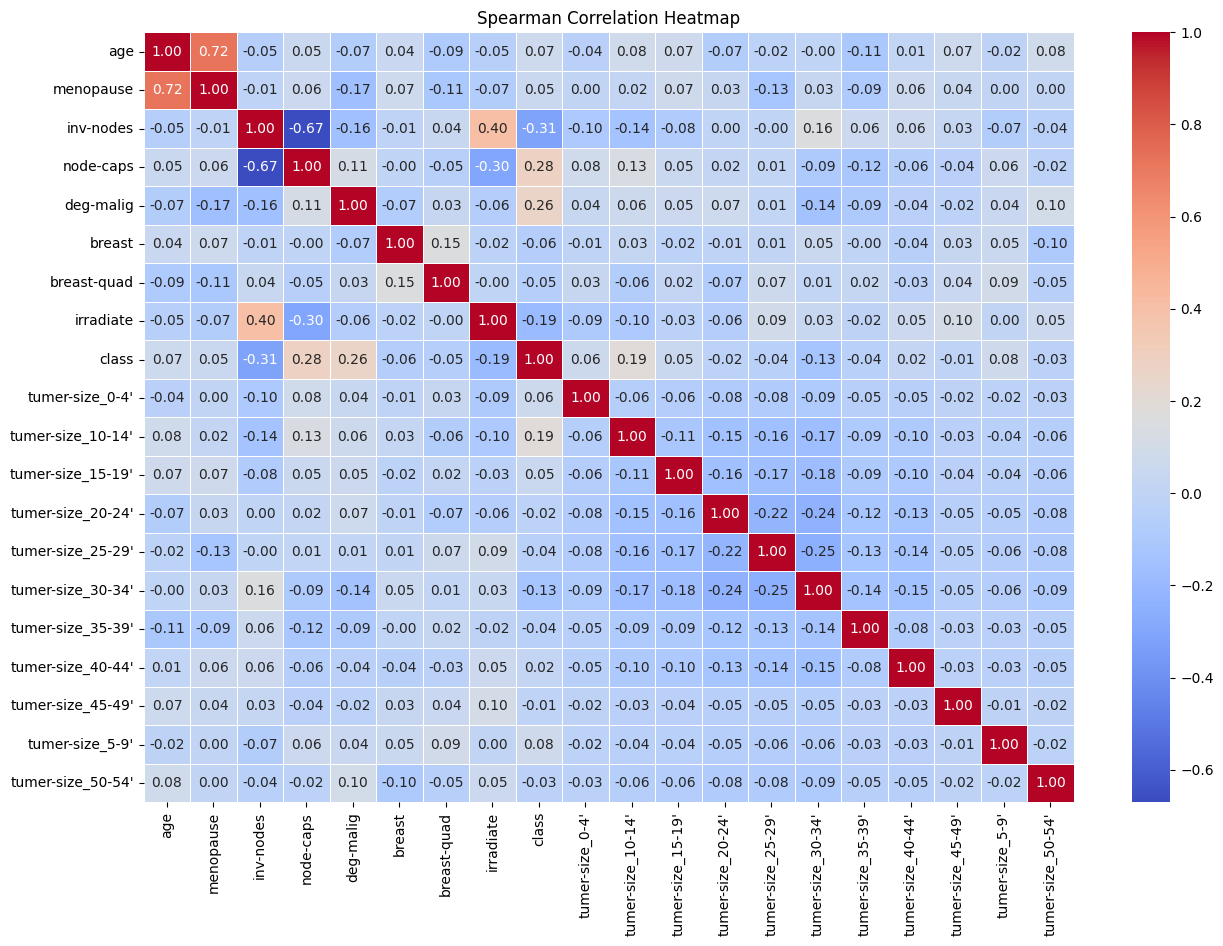


Pairs of features with absolute Spearman correlation greater than 0.8:
No highly correlated pairs found above the specified threshold.


In [ ]:
# Calculate the Spearman correlation matrix
corr_matrix = df_encoded.corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Spearman Correlation Heatmap')
plt.show()

# Set the correlation threshold
threshold = 0.8

# Find highly correlated pairs (excluding self-correlation)
highly_correlated_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            highly_correlated_pairs.append((colname_i, colname_j, corr_matrix.iloc[i, j]))

# Display the highly correlated pairs
print(f"\nPairs of features with absolute Spearman correlation greater than {threshold}:")
if highly_correlated_pairs:
    for pair in highly_correlated_pairs:
        print(f" - {pair[0]} and {pair[1]}: {pair[2]:.2f}")
else:
    print("No highly correlated pairs found above the specified threshold.")

In [ ]:
# Calculate variance for each column
variances = df_encoded.var()

# common approach is to look for features with variance close to zero
variance_threshold = 0.01

# Identify features with variance below the threshold
low_variance_features = variances[variances < variance_threshold].index.tolist()

print(f"Features with variance below the threshold ({variance_threshold}):")
if low_variance_features:
    for feature in low_variance_features:
        print(f"- {feature}: {variances[feature]:.4f}")

    # Drop the low variance features
    df_encoded = df_encoded.drop(columns=low_variance_features)
    print(f"\nDropped the following low variance features: {low_variance_features}")
else:
    print("No features found with variance below the specified threshold.")




Features with variance below the threshold (0.01):
No features found with variance below the specified threshold.


In [ ]:
df_encoded.to_csv('Processed_breast_cancer_data.csv', index=False)

print("Updated DataFrame saved to 'breast_cancer_encoded.csv")

Updated DataFrame saved to 'breast_cancer_encoded.csv
